In [2]:
#Librerias
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.callbacks import *
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Activation,Flatten,Dropout,GlobalAveragePooling2D,ZeroPadding2D,AveragePooling2D
from tensorflow import keras
from keras.applications.mobilenet import MobileNet
import glob as gb
import cv2
import os
import shutil
from mtcnn import MTCNN

In [28]:
# Genera el dataset a partir de imágenes generadas por StyleGAN3
# Clasifica las imágenes por edad, genero , o si tiene gafas o no y las copia a su respectiva carpeta


In [3]:
# Fake-Real clasificador
# Modelo convolucional

model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',
                            input_shape= (512,512,3)),
            tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
            tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(32, activation=tf.nn.relu),
            tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

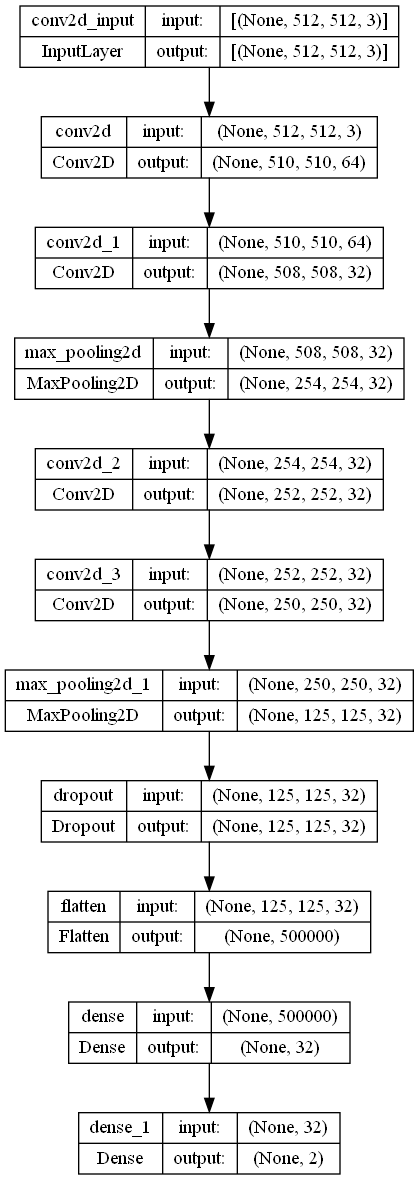

In [4]:
tf.keras.utils.plot_model(model, to_file='convRealFakeModel.png', show_shapes=True)

In [4]:
model.load_weights("modelos/clasificadorRealFalso/model3-real-fake.h5")

In [5]:
# Clasificador de edad
mobilenet = MobileNet(input_shape= (200,200,3),include_top= False,weights=None)

age_model = Sequential()
age_model.add(mobilenet)
age_model.add(GlobalAveragePooling2D())
age_model.add(Dropout(0.25))
age_model.add(Dense(5,activation='softmax'))

age_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [6]:
age_model.load_weights("modelos/clasificadorEdad/mobilenet.h5")

In [7]:
#Clasificador por genero
gender_model = Sequential()

gender_model.add(Conv2D(filters =64, kernel_size = (6,6), padding = "Same", activation = "relu", input_shape = (200,200,3)))
gender_model.add(AveragePooling2D(2,2))

gender_model.add(Conv2D(128,(3,3),activation="relu"))
gender_model.add(AveragePooling2D(2,2))

gender_model.add(Conv2D(256,(3,3),activation="relu"))
gender_model.add(AveragePooling2D(2,2))

gender_model.add(Conv2D(512,(3,3),activation="relu"))
gender_model.add(AveragePooling2D(2,2))

gender_model.add(Conv2D(512,(3,3),activation="relu"))
gender_model.add(GlobalAveragePooling2D())

gender_model.add(Dense(512))
gender_model.add(Activation("relu"))
gender_model.add(Dropout(0.25))
gender_model.add(Dense(2))
gender_model.add(Activation("softmax"))

gender_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 200, 200, 64)      6976      
                                                                 
 average_pooling2d (AverageP  (None, 100, 100, 64)     0         
 ooling2D)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 98, 98, 128)       73856     
                                                                 
 average_pooling2d_1 (Averag  (None, 49, 49, 128)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_6 (Conv2D)           (None, 47, 47, 256)       295168    
                                                                 
 average_pooling2d_2 (Averag  (None, 23, 23, 256)     

In [8]:
gender_model.load_weights('modelos/clasificadorGenero/model2.h5')

In [9]:
#Deteccion de cara para recorte
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')

In [10]:
detector = MTCNN() #Deteccion de cara para puntos relevantes (ojos, nariz, boca, etc)
def have_glasses(filepath):
    # image = cv2.cvtColor(cv2.imread('stylegan3/out/seed70375.png'),cv2.COLOR_BGR2RGB)
    image = cv2.imread(filepath) #Carga imagen
    image = cv2.cvtColor(image,cv2.IMREAD_COLOR)
    result = detector.detect_faces(image)
    if(result != []): #Recorte de la zona entre ojos
        x1 = result[0].get('keypoints').get('left_eye')[0]
        x2 = result[0].get('keypoints').get('right_eye')[0]
        y1 = result[0].get('keypoints').get('left_eye')[1]
        y2 = result[0].get('keypoints').get('right_eye')[1]
        
        print(x1)
        print(x2)
        print(y1)
        print(y2)
        y1 = y1 - 30
        y2 = y2 + 30
        x1 = x1 + 65
        x2 = x2 - 65
        img = image[y1:y2, x1:x2]

        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, threshold1=100, threshold2=350)

        if 255 in edges: #Si se detecta un borde tiene gafas.
            return True
        else :
            return False
    else :
        return False

In [11]:
def group_age(group): #Definicion de los grupos de edad
    if group == 1 :
        return "0-15"
    if group == 2 :
        return "16-25"
    if group == 3 :
        return "26-40"
    if group == 4 :
        return "41-60"
    else : return "+60"

In [12]:
for ix in range(10):
    img_path = gb.glob('stylegan3/out/*.png')
    for path in img_path:
        img = keras.utils.load_img(path,target_size=(512,512)) #Carga de la imagen
        img_array = keras.utils.img_to_array(img)
        img_array = img_array.astype(np.float32) / 255.0
        test_img = np.array([img_array])
        predictions = model.predict(test_img) #Prediccion real o falsa.
        if predictions[0,1] > 0.5 :
            img = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
            faces = face_cascade.detectMultiScale(img, 1.1, 4) #Seleccion de la cara y posterior recorte
            for (x, y, w, h) in faces:
                faces = img[y:y + h, x:x + w]
            if len(faces) > 0:
                resized = cv2.resize(faces, (200,200))
                faces = np.array([resized])
                faces = faces / 255

                prediction = age_model.predict(faces)    #Prediccion de la edad
                age_group = prediction.argmax()
                prediction = gender_model.predict(faces) #Prediccion del género
                gender = prediction.argmax()
                glasses = have_glasses(path) #Tiene gafas o no.
                
                #print(age_group)
                #print(gender)
                #print(glasses)
                name = path.split('/')
                name2 = name[1].split('\\')
                
                if(age_group == 0) : #Copia a distintas carpetas dependiendo las predicciones.
                    if(gender == 0):
                        if(glasses) :
                            resultpath = 'new_data/' + 'young' +'/female' + '/glasses/' + name2[1]
                            shutil.copyfile(path,resultpath)
                        else :
                            resultpath = 'new_data/' + 'young' +'/female' + '/noglasses/' + name2[1]
                            shutil.copyfile(path,resultpath)
                    else :
                        if(glasses) :
                            resultpath = 'new_data/' + 'young' +'/male' + '/glasses/' + name2[1]
                            shutil.copyfile(path,resultpath)
                        else :
                            resultpath = 'new_data/' + 'young' +'/male' + '/noglasses/' + name2[1]
                            shutil.copyfile(path,resultpath)
                elif(age_group > 1) :
                    if(gender == 0):
                        if(glasses) :
                            resultpath = 'new_data/' + 'adult' +'/female' + '/glasses/' + name2[1]
                            shutil.copyfile(path,resultpath)
                        else :
                            resultpath = 'new_data/' + 'adult' +'/female' + '/noglasses/' + name2[1]
                            shutil.copyfile(path,resultpath)
                    else :
                        if(glasses) :
                            resultpath = 'new_data/' + 'adult' +'/male' + '/glasses/' + name2[1]
                            shutil.copyfile(path,resultpath)
                        else :
                            resultpath = 'new_data/' + 'adult' +'/male' + '/noglasses/' + name2[1]
                            shutil.copyfile(path,resultpath)
                
        os.remove(path)

1/1 [==============================] - 0s 90ms/step
385
645
483
483
3
1
False
1/1 [==============================] - 0s 26ms/step
385
643
478
481
0
0
False
1/1 [==============================] - 0s 30ms/step
379
640
485
485
2
1
False
1/1 [==============================] - 0s 25ms/step
386
651
488
483
2
1
False
1/1 [==============================] - 0s 13ms/step
382
640
485
483
2
1
False
1/1 [==============================] - 0s 14ms/step
388
649
486
491
3
1
True
1/1 [==============================] - 0s 31ms/step
375
652
484
480
3
1
True
1/1 [==============================] - 0s 32ms/step
383
640
486
484
3
1
False
1/1 [==============================] - 0s 13ms/step
380
646
487
486
4
1
False
1/1 [==============================] - 0s 29ms/step
384
645
486
485
0
0
False
1/1 [==============================] - 0s 14ms/step
383
647
482
479
0
0
False
1/1 [==============================] - 0s 13ms/step
387
638
481
480
3
1
False
1/1 [==============================] - 0s 14ms/step
389
645
481
48